# Predict Weights with new datasets
- validation data was used
- inception-resnet-v2 added
- formed 2 types of scale

In [18]:
import os
import fnmatch
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

rootpath = '/media/share/data/Tremella_fuciformis/'

# Generat Dataframe

In [19]:
# For DL purpose, high qulity image
def label_cleaning(root_path):
    
    filename = sorted([idx for idx in Path(root_path).glob('*/*.xlsx')])

    df_all = pd.DataFrame([])
    for idx in filename[10:]:
        df = pd.read_excel(idx, header=1)
        sn = pd.DataFrame(df['號碼.1'].str.split('-').str[0])
        cansn = pd.DataFrame(df['號碼.1'].str.split('-').str[1])
        df_temp = pd.concat([sn, cansn, df['平均單朵重量'], df['取樣天數']], 1)
        df_temp = df_temp.dropna()
        # add production sn
        psn = pd.DataFrame(np.repeat([os.path.basename(idx).split('.')[0]], len(df_temp)), columns=['PSN'])
        df_temp = pd.concat([psn.reset_index(drop=True), df_temp.reset_index(drop=True)], 1)

        df_all = pd.concat([df_all, df_temp], 0)

    df_all.columns = ['PSN', 'SN', 'CanSN', 'Weight', 'Days']
    
    return df_all

In [20]:
df_train = label_cleaning(rootpath)

# delet mis-matched label
df_train['SN'] = pd.to_numeric(df_train['SN'], errors='coerce')
df_train = df_train.dropna()
df_train['SN'] = pd.to_numeric(df_train['SN'], downcast='integer')

df_train.reset_index(drop=True, inplace=True)
df_train.sample(5)

,PSN,SN,CanSN,Weight,Days
173,T8-171229,5,25,42.791667,38.0
4,T8-171227,2,7,10.458333,36.0
335,T8-180119,5,4,83.666667,39.0
400,T8-180124,8,6,57.638889,36.0
378,T8-180124,5,13,61.833333,36.0


# Image Preprocess and Augmentation steps

In [5]:
!pip install imgaug

    100% |████████████████████████████████| 563kB 1.3MB/s 
  Running setup.py bdist_wheel for imgaug ... done
  Stored in directory: /home/jovyan/.cache/pip/wheels/7e/a1/8d/539b1e9c828007360ec8684168a0b368e79bee302cef062c8e
Successfully built imgaug


In [23]:
def img_proc(img):
    
    import numpy as np
    from skimage.color import rgb2gray
    from skimage.feature import canny
    from skimage.morphology import disk, closing
    from skimage.morphology import remove_small_objects
    from skimage.measure import label, regionprops

    img1 = rgb2gray(img)
    img2 = canny(img1)
    img3 = closing(img2, disk(5))
    img4 = remove_small_objects(img3)

    # search largest area
    label_img = label(img4)

    bbarea = []
    for region in regionprops(label_img):
        bbarea.append(region.area)

    minr, minc, maxr, maxc = regionprops(label_img)[bbarea.index(np.max(bbarea))].bbox
    crop_img = img[minr:maxr, minc:maxc]
    
    return crop_img

In [34]:
from multiprocessing import Pool, cpu_count

def img_aug(idx):
    
    from skimage.transform import resize
    import imgaug as ia
    from imgaug import augmenters as iaa
    from random import shuffle
    
    ia.seed(np.random.randint(1, 2**10))
    
    # aug_parameters
    seq = iaa.Sequential([
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5),
        iaa.Affine(
            rotate=(-45, 45), # rotate by -45 to +45 degrees
            mode='constant'
        ),
        iaa.GaussianBlur((0.0, 1.0))
    ], random_order=True)
    

    rows, cols = 299, 299
    
    subpath = os.path.join(rootpath, df_train['PSN'].iloc[idx])
    sn = str(df_train['SN'].iloc[idx])
    csn = str(df_train['CanSN'].iloc[idx])
    img = plt.imread(subpath + '/' + sn + '/' + csn + '.JPG')

    if img.shape[0] > img.shape[1]:
        img = np.transpose(img, (1, 0, 2))

    # roi segmentation
    img = img_proc(img)

    # augment
    img = seq.augment_image(img)

    # resize
    img_file = resize(img, (rows, cols, 3), mode='edge')

    # load y value
    label = df_train['Weight'].iloc[idx]

    return img_file, label

In [35]:
def img_gen(indexlist, runs):
    from random import shuffle
    import itertools
    
    img_files = []
    labels = []
    
    for i in range(runs):
        shuffle(indexlist)
        with Pool(cpu_count()) as pool:
            img_file, label = zip(*pool.map(img_aug, indexlist))

        img_files += img_file
        labels += label
        
    return np.array(img_files), np.array(labels)

In [9]:
## MultiGPU Code
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
set_session(tf.Session(config=config))

import keras.utils.training_utils
from keras.utils import multi_gpu_model
gdev = keras.utils.training_utils._get_available_devices()
gdev_count = 0
for i, n in enumerate(gdev):
    if 'device:GPU' in n:
        gdev_count+=1
if gdev_count > 0:
    print('Found {} GPUs, will attempt to use all of them.'.format(gdev_count))
else:
    gdev_count=1
    print('Did not find any GPUs, this will be SLOW!')

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Found 8 GPUs, will attempt to use all of them.


# CNN models (Densenet-201)

In [10]:
import keras.backend as K
from keras.applications.densenet import DenseNet201 as basenet1
# from keras.applications.inception_resnet_v2 import InceptionResNetV2 as basenet2
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Average
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam

K.clear_session()
base_model1 = basenet1(include_top=False, weights='imagenet', input_shape=(299, 299, 3))
x = GlobalAveragePooling2D()(base_model1.output)
x = Dense(1, activation='relu')(x)

smodel = Model(inputs=base_model1.input, outputs=x)
smodel.summary()

# Multimodel
if gdev_count > 1:
    model = multi_gpu_model(smodel, gdev_count)
    model.summary()
else:
    model = smodel

76398592/76391848 [==============================] - 188s 2us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 305, 305, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 150, 150, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 150, 150, 64) 256         conv1/conv[0][0]                 
__________________________________________

In [36]:
# self identified index
def acc1(y_true, y_pred):
    return K.mean(K.less_equal(K.abs(y_pred - y_true), K.ones_like(y_true)*10), axis=-1)
def acc2(y_true, y_pred):
    return K.mean(K.less_equal(K.abs(y_pred - y_true), K.ones_like(y_true)*15), axis=-1)
# def acc3(y_true, y_pred):
#     return K.mean(K.less_equal(K.abs(y_pred - y_true), K.ones_like(y_true)*15), axis=-1)

model.compile(optimizer='adam', loss='mse', metrics=[acc1, acc2])

# Trainning

In [37]:
from sklearn.model_selection import KFold

n_flod = 7

kf = KFold(n_flod, shuffle=True, random_state=np.random)
for train_idx, val_idx in kf.split(df_train):
    break
    
print(len(train_idx))

321


In [38]:
# runs = 16
train_imgs, train_labels = img_gen(train_idx, 16)
val_imgs, val_labels = img_gen(val_idx, 32)

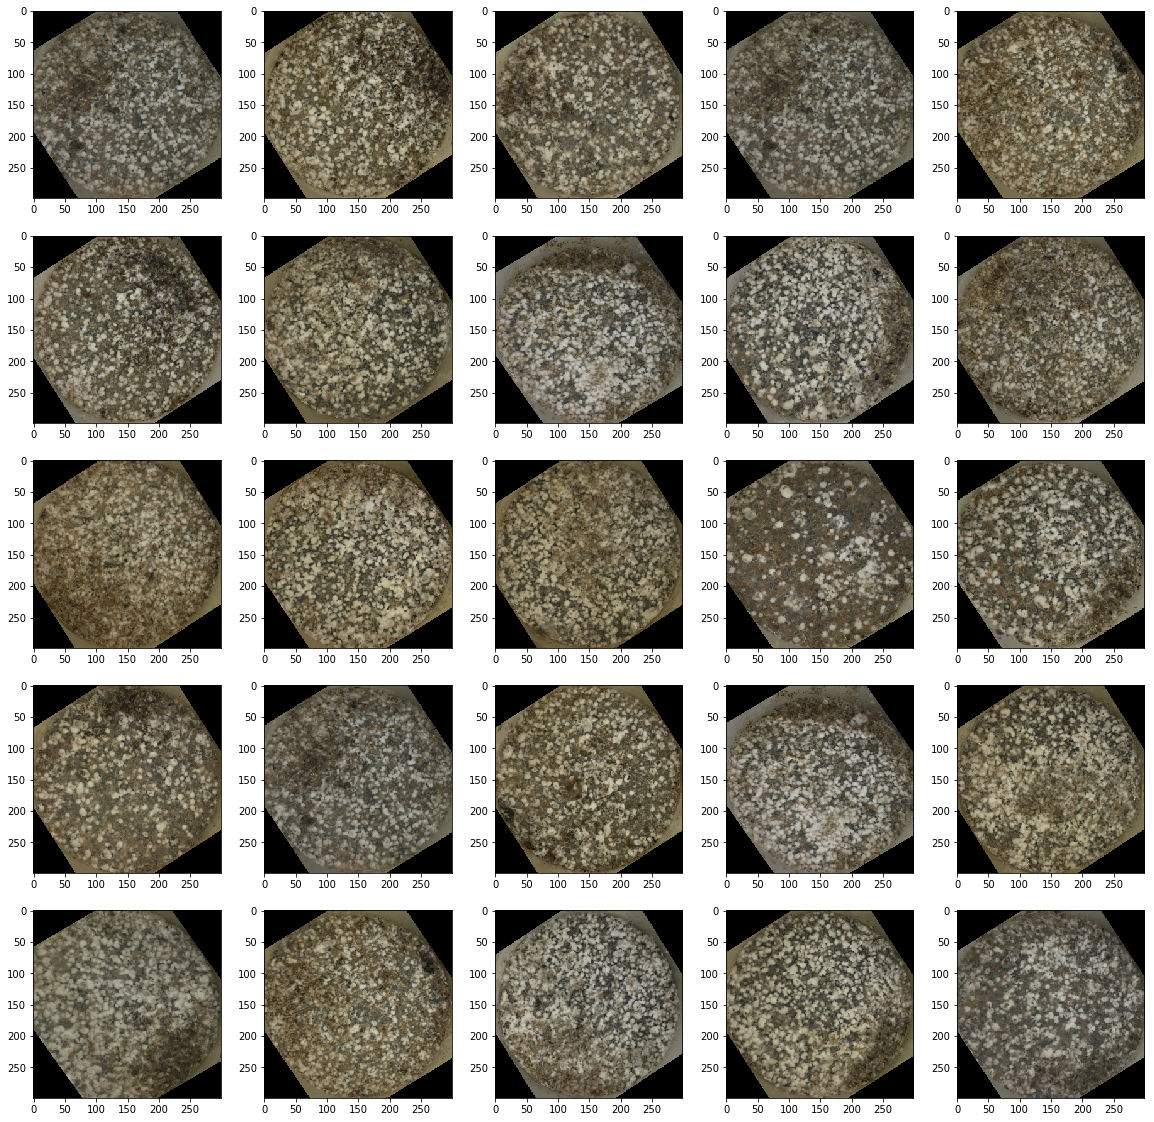

In [ ]:
# Show some sample images @ken
from random import sample

fig = plt.figure(figsize=(20, 20))
for i, n in enumerate(sample(list(val_imgs), 25)):
    ax = fig.add_subplot(5, 5, i+1)
    ax.imshow(n)

In [37]:
model.compile(optimizer=Adam(lr=0.02), loss='mse', metrics=[acc1, acc2])

In [ ]:
# model.load_weights('t8_mse-val_loss.hdf5')

model_checkpoint1 = ModelCheckpoint('t8_mse-val_acc2.hdf5',
                                   monitor='val_acc2', save_best_only=True, save_weights_only=True)
model_checkpoint2 = ModelCheckpoint('t8_mse-val_loss.hdf5',
                                    monitor='val_loss', save_best_only=True, save_weights_only=True)

# adlr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=8, verbose=0, mode='auto', epsilon=0.0001, cooldown=0, min_lr=1e-6)
model_earlystop = EarlyStopping(patience=64, monitor='val_loss')

batch_size = 16 * gdev_count

train_history = model.fit(train_imgs, train_labels, 
                          batch_size=batch_size, 
                          epochs=2**10, 
                          validation_data=(val_imgs, val_labels),
                          verbose=2, 
                          callbacks=[model_checkpoint1, 
                                     model_checkpoint2, 
                                     model_earlystop])

Train on 5136 samples, validate on 1296 samples
Epoch 1/1024
 - 173s - loss: 395.4471 - acc1: 0.4798 - acc2: 0.6507 - val_loss: 3759.1138 - val_acc1: 0.0123 - val_acc2: 0.0123
Epoch 2/1024
 - 83s - loss: 455.3507 - acc1: 0.4603 - acc2: 0.6410 - val_loss: 3759.1138 - val_acc1: 0.0123 - val_acc2: 0.0123
Epoch 3/1024
 - 81s - loss: 372.2873 - acc1: 0.4891 - acc2: 0.6639 - val_loss: 3759.1138 - val_acc1: 0.0123 - val_acc2: 0.0123
Epoch 4/1024
 - 80s - loss: 417.0762 - acc1: 0.4675 - acc2: 0.6451 - val_loss: 3759.1138 - val_acc1: 0.0123 - val_acc2: 0.0123
Epoch 5/1024
 - 80s - loss: 214.4209 - acc1: 0.5317 - acc2: 0.7245 - val_loss: 318.3214 - val_acc1: 0.4344 - val_acc2: 0.6057
Epoch 6/1024
 - 80s - loss: 194.0872 - acc1: 0.5329 - acc2: 0.7447 - val_loss: 344.7841 - val_acc1: 0.3580 - val_acc2: 0.5309
Epoch 7/1024
 - 80s - loss: 182.2258 - acc1: 0.5561 - acc2: 0.7432 - val_loss: 287.3083 - val_acc1: 0.3850 - val_acc2: 0.5926
Epoch 8/1024
 - 79s - loss: 176.1380 - acc1: 0.5703 - acc2: 0.756

# Evaluation

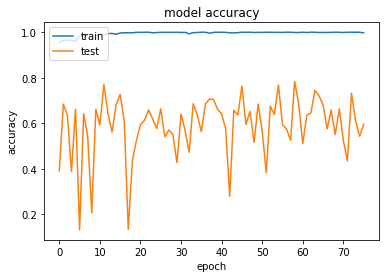

In [43]:
plt.plot(train_history.history['acc3'][12:])
plt.plot(train_history.history['val_acc3'][12:])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

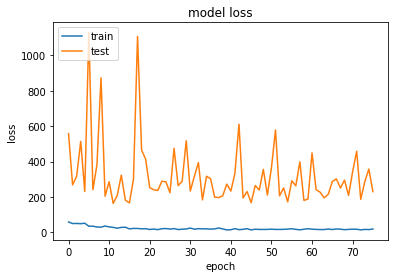

In [41]:
plt.plot(train_history.history['loss'][12:])
plt.plot(train_history.history['val_loss'][12:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [41]:
model.load_weights('fungus-test20180201-smcw-16-0.8467.hdf5')
model.evaluate(X_val, y_val)

In [ ]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_val).argmax(axis=-1)
print(classification_report(y_val.argmax(axis=-1), y_pred, target_names=['A-60', 'B-60']))

In [18]:
model.load_weights('t8_val_loss.hdf5')
# model.save('t8_weight.hdf5')

In [52]:
modelx = model.get_layer('model_1')

In [53]:
modelx.save('t8_weight.h5')

# Prediction

In [ ]:
img = plt.imread('/media/share/data/Tremella_fuciformis/T8-170705/image_5.jpg')
img = resize(img, (256, 256, 3), mode='reflect')
# img = img[np.newaxis, :, :, :]

In [ ]:
y_pred = model.predict(img)

# Testing

In [19]:
import os
import fnmatch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import load_model
from skimage.transform import resize
import fnmatch

# model = load_model('/media/share/jiaxin_cmu/Tremella_fuciformis_v1/t8_weight.h5')
testpath = '/media/share/data/Tremella_fuciformis/validation/'
valdir = os.listdir(testpath)
valdir.remove('prediction_T8.csv')
test_img = []

for idx in valdir:
    subpath = os.path.join(testpath, idx)
    subdir = fnmatch.filter(os.listdir(subpath), '*_val')
    for iidx in subdir:
        canpath = os.path.join(subpath, iidx)
        candir = os.listdir(canpath)
        for jdx in candir:
            imgpath = os.path.join(canpath, jdx)
            images = fnmatch.filter(os.listdir(imgpath), '*.JPG')
            SN = idx + '/' + iidx + '/' + jdx
            test_img.append((SN, images))
        
test_df = pd.DataFrame(test_img, columns=['SN', 'image'])

In [ ]:
y_pred = []

for idx in range(len(test_df)):
    filepath = os.path.join(testpath, test_df['SN'].iloc[idx])
    for iidx in test_df['image'].iloc[idx]:
        img = plt.imread(filepath + '/' + iidx)
        if img.shape[0] > img.shape[1]:
            img = np.transpose(img, (1, 0, 2))
        img = [resize(img, (224, 224, 3), mode='reflect')[np.newaxis, :, :, :], resize(img, (299, 299, 3), mode='reflect')[np.newaxis, :, :, :]]
#         img = img[np.newaxis, :, :, :]
        y_pred.append((test_df['SN'].iloc[idx], iidx, model.predict(img)))

In [ ]:
y_pred

In [ ]:
%%javascript
Jupyter.notebook.session.delete();